In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import collections
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import pickle
from extract_features import *
from detect_vehicles import *
%matplotlib inline

calibration mtx and dist loaded. img_size=(1280, 720)


In [2]:
# read cars and notcars images
cars, notcars = load_data()

8792 cars
8968 non-cars


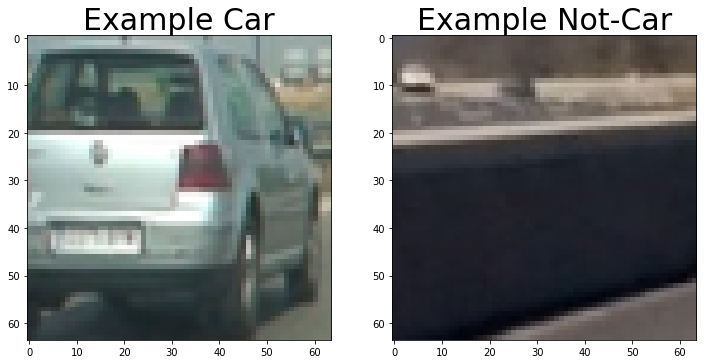

In [3]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
car_img = mpimg.imread(cars[ind])

# Generate a random index to look at a car image
ind = np.random.randint(0, len(notcars))
# Read in the image
notcar_img = mpimg.imread(notcars[ind])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9))
ax1.imshow(car_img)
ax1.set_title('Example Car', fontsize=30)
ax2.imshow(notcar_img)
ax2.set_title('Example Not-Car', fontsize=30)
#f.savefig('output_images/example.jpg')

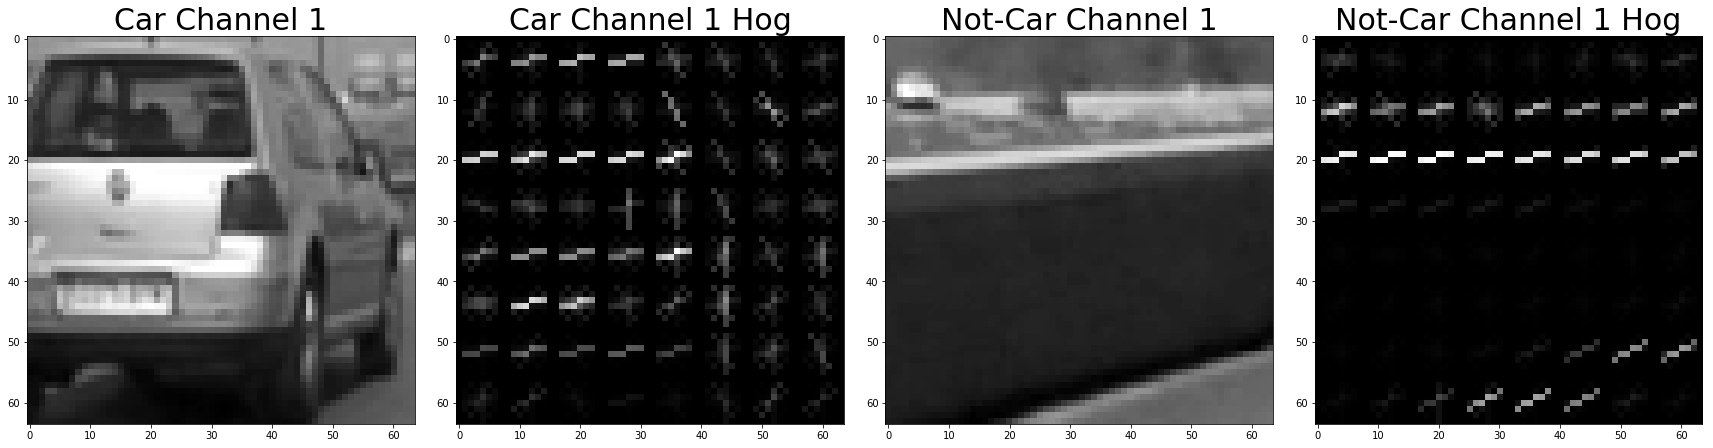

In [4]:
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
fig = plt.figure()
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()

i = 0
yuv = cv2.cvtColor(car_img, cv2.COLOR_RGB2YUV)
ch1 = yuv[:,:,i]
features, hog_image = get_hog_features(ch1, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

#plt.subplot(141)
ax1.imshow(ch1, cmap='gray')
ax1.set_title('Car Channel {}'.format(i + 1), fontsize=30)
#plt.subplot(142)
ax2.imshow(hog_image, cmap='gray')
ax2.set_title('Car Channel {} Hog'.format(i + 1), fontsize=30)

yuv = cv2.cvtColor(notcar_img, cv2.COLOR_RGB2YUV)
ch1 = yuv[:,:,i]
features, hog_image = get_hog_features(ch1, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

#plt.subplot(143)
ax3.imshow(ch1, cmap='gray')
ax3.set_title('Not-Car Channel {}'.format(i + 1), fontsize=30)
#plt.subplot(144)
ax4.imshow(hog_image, cmap='gray')
ax4.set_title('Not-Car Channel {} Hog'.format(i + 1), fontsize=30)
#f.savefig('output_images/example_hog.jpg')

In [5]:
dist_pickle = pickle.load( open("svc_pickle_all.p", "rb" ) )
svc = dist_pickle["svc"] 
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

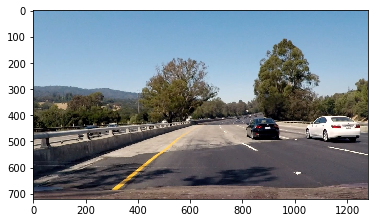

In [6]:
img = mpimg.imread('../test_images/test4.jpg')
plt.imshow(img)

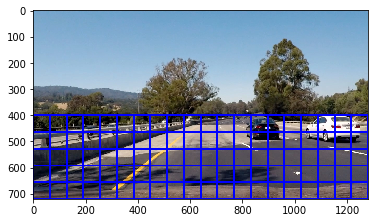

In [7]:
windows = slide_window(img, x_start_stop=[None, None], y_start_stop=[400, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(img, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
#plt.savefig('../output_images/sliding_windows.jpg')

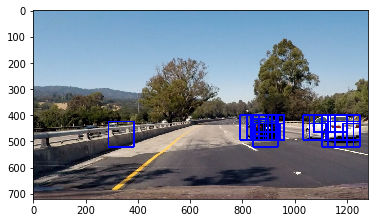

In [8]:
xstart = 0
xstop = 1280
ystart = 400
ystop = 650
scales = [1.0, 1.5]
    
box_list = find_cars(img, xstart, xstop, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_conv='RGB2YUV')
out_img = draw_boxes(img, box_list)
plt.imshow(out_img)
plt.savefig('../output_images/bboxes.jpg')

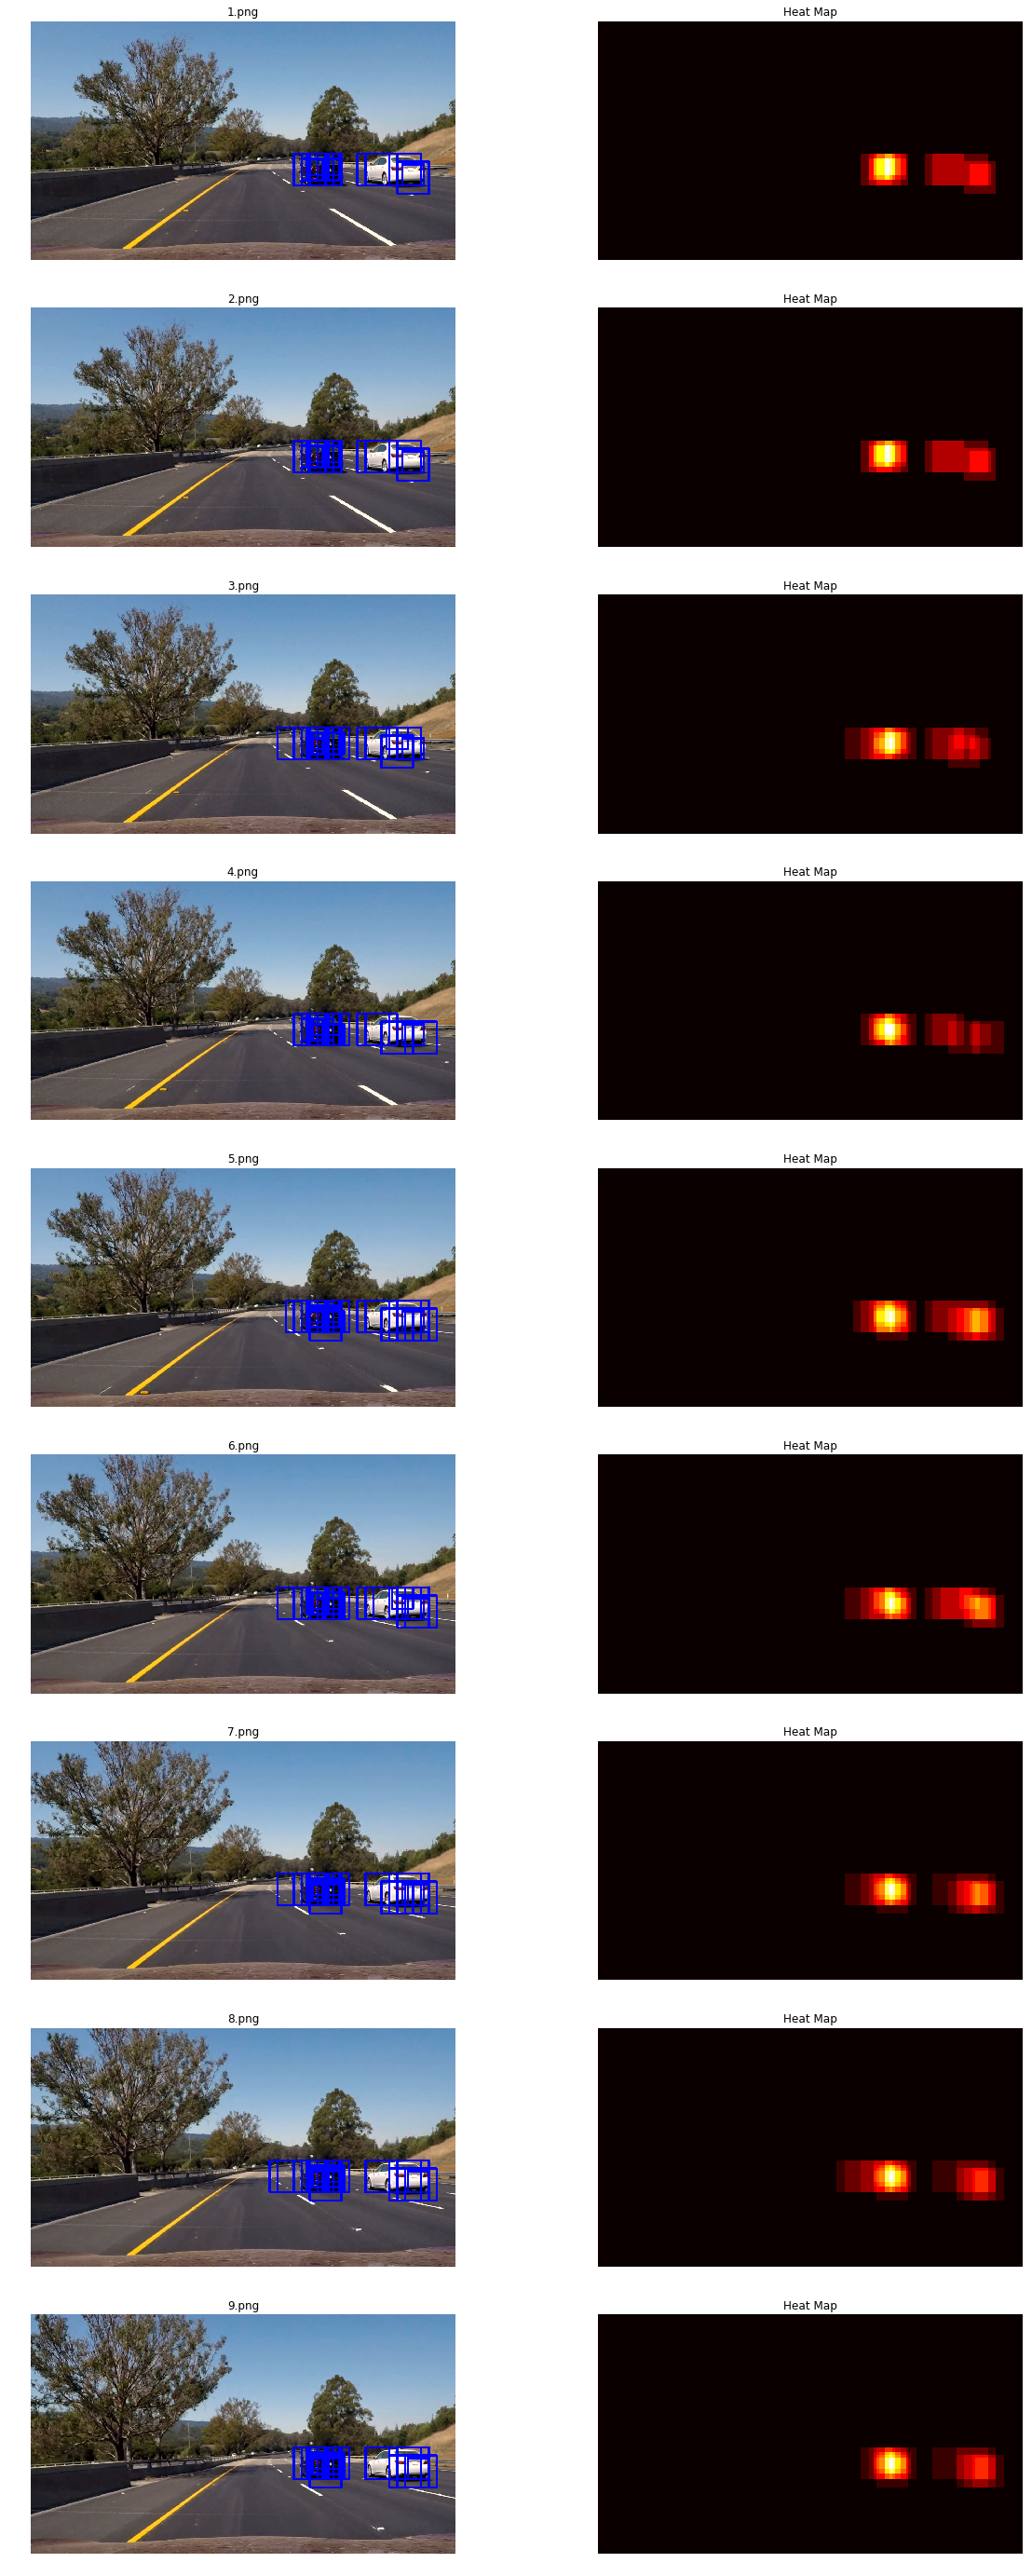

In [9]:
import matplotlib.gridspec as gridspec
images = glob.glob('../test_video_images/*.png')
gs = gridspec.GridSpec(9, 2, wspace=0.0, hspace=0.0)
fig = plt.figure(figsize=(20, 50))
c = 1
for file in images:
    img = cv2.imread(file)  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    box_list = find_cars(img, xstart, xstop, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_conv='RGB2YUV')    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    #heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    #labels = label(heatmap)
    #draw_img = draw_labeled_bboxes(np.copy(img), labels)
    draw_img = draw_boxes(img, box_list)
    
    plt.subplot(9, 2, c)
    plt.imshow(draw_img)
    plt.title(file[(file.rfind('\\')+1):])
    plt.axis('off')
    #plt.subplot(c * 100 + 22)
    plt.subplot(9, 2, c + 1)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    plt.axis('off')
    c += 2
   
plt.show()
#fig.savefig('../output_images/bboxes_heatmap.jpg')


(-0.5, 1279.5, 719.5, -0.5)

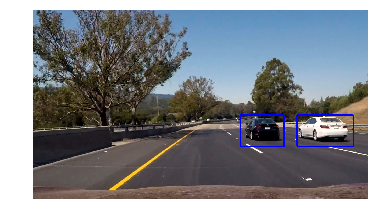

In [10]:
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)
plt.imshow(draw_img)
plt.axis('off')
#plt.savefig('../output_images/output_bboxes.jpg')